# Programming Assignment 1: Linear Regression

## Part I: Introduction of Various Linear Regression Fitting Methods

### Import the packages

In class, we have learned linear regression. In this section, we will take through a simple experiment to see how it works. We are going to use `numpy` , `pandas`, `matplotlib` and `tensorboardX` packages in Python, the first thing we need to do is to import them.

In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
# time packages are used to measure the convergence speed
import time
# there might be some warnings due to the different versions of python and packages you installed.
# here we choose to suppress these warnings.
# but don't ignore warnings unless you know you are absolutely right!
import warnings
warnings.filterwarnings("ignore")
num_features = 15
print('Done')

Done


In [2]:
print('Hello World!')

Hello World!


## I. Linear Regression Using Normal Equation

Our experiment consists of three steps:
1. Generation of training dataset.
2. Implementation of our models
3. Visualization of experimental results.

And we will have an (analytical) open question in the end.

### Generation of training dataset
Linear model is defined as
$$
\begin{aligned}
\boldsymbol{y}=\boldsymbol {X \boldsymbol\theta}+ \boldsymbol \varepsilon,
\end{aligned}
$$

where $\boldsymbol X = [\boldsymbol x^{(1)}\cdots \boldsymbol x^{(m)}]^T$ is the observation matrix which consists of $m$ samples, $\boldsymbol x^{(i)}$ is the feature vector of $i$-th sample, whose length is also known as *the number of features*; $\boldsymbol \theta$ is the weight vector, and $\boldsymbol\varepsilon$ is the Gaussian noise. We will generate training data based on the defination of linear model. Here the number of features is set to $2$. For simplicity, we just set $\boldsymbol \theta = \boldsymbol 1$, where $\boldsymbol 1$ is a vector with all components equal to $1$.

In [3]:
num_features = 2
theta_ = np.array([1, 1])


Given the the number of samples, we generate a random observation matrix $\boldsymbol X$. The corresponding labels $\boldsymbol y$ are computed through $\boldsymbol{X\theta}$ plus Gaussian noise.

In [20]:
num_samples = 100

def generate_data(num_samples, num_features, scale, function):
    # range of x: [-0.5, 0.5]
    X = np.random.rand(num_samples, num_features)-0.5
    # X@y is equivalent to np.matmul(X, y)
    y = function(X) + np.random.normal(scale=scale, size=(num_samples))
    return X, y
# $y = X \cdot \theta$
def func1(X):
    return X @ theta_

X, y = generate_data(num_samples, num_features, 0.2, func1)

### Implementation of our models
In real-world problems, we can only get $\boldsymbol {X}$ and $\boldsymbol {y}$. $\boldsymbol\theta$ is the weight vector we want to esimate through linear regression. To minimize the noise effect, we do a minimization problem
$$
\min _{\boldsymbol\theta}\|\boldsymbol y-\boldsymbol X \boldsymbol{\theta}\|^{2}
$$
and we can get the best estimator by solving the normal equation
$$
\boldsymbol X^{T} \boldsymbol {X\theta}=\boldsymbol{X}^T \boldsymbol{y},\\
\boldsymbol \theta =  (\boldsymbol X^{T} \boldsymbol X^T)^{-1} \boldsymbol{X}^T \boldsymbol{y}.
$$
Transfer the above formula into code and we get the analytical solution of linear regression. In the review section, we have learned that the inversion of matrix can be computed through `numpy.linalg.inv`.

In [21]:
def linear_regression(X, y):
    return np.linalg.inv((X.transpose()@X))@X.transpose()@y

theta_linear_regression = linear_regression(X, y)
print('the estimated parameter using normal equation is {}'.format(theta_linear_regression))

the estimated parameter using normal equation is [1.14849857 0.82672855]


We have finished estimating the parameter of a linear regression model by normal equation, and the result turns out to be well fitted.

However, we also learned another methood, Gradient Descent, to update the parameter till optimal. Let's implement it and compare the result with the one using analytical method.

## II. Linear Regression Using Batch Gradient Descent

### Implementation of our models
In this method, we want to use gradient descent to find the optimal $\theta$ to minimize the least square error
$$
\begin{aligned}
min J(\theta) = 
& \min _{\boldsymbol\theta}\frac{1}{2}\|\boldsymbol y-\boldsymbol X \boldsymbol{\theta}\|^{2} \\
= & \min _{\boldsymbol\theta}\frac{1}{2} (X\theta-Y)^T(X\theta-Y).
\end{aligned}
$$

Rewriting the error into Matrix format to process with batches of data will greatly accelerate the running. 

From the review seesion of the calculus, we have learned that the gradient of the aforementioned expression of theta is
$$
\begin{aligned}
\nabla J(\boldsymbol\theta) = & \frac{\partial \frac{1}{2} (X\theta-Y)^T(X\theta-Y)}{\partial \theta} \\
= & \boldsymbol X^TX\theta - X^TY
\end{aligned}
$$

So we can use this gradient to iteratively update the parameter through
$$
\boldsymbol\theta := \boldsymbol\theta - \alpha \nabla J(\boldsymbol\theta),
$$
where $\alpha$ is the learning rate. Since we want to maximize $\mathcal l(\boldsymbol \theta)$, the update rule becomes
$$
\boldsymbol \theta:=\boldsymbol \theta+ \alpha (\boldsymbol X^TX\theta - X^TY).
$$
Now we transfer this formula into codes. Instead of using a for-loop, we prefer to use matrix operations as it's much more efficient.

In [6]:
# first we initialize the theta
theta_linear_regression_2 = np.zeros(num_features)
theta_linear_regression_2

array([0., 0.])

Now, we implement the batch gradient descent algorithm for linear regression as follows.

In [7]:
# we set up some coefficiency of our linear regression model
max_epoch = 5000
alpha = 0.01

# initialize the writer
writer = SummaryWriter('logs')

# function to compute the error
def LSError(X, y, theta):
    return np.linalg.norm(np.matmul(X, theta)-y)

# implementation of batch gradient descent
def BGD(X, y, max_epoch, alpha, theta_linear_regression):
    for epoch in range(max_epoch):
        # if the least square error is small enough, we can stop the iterative update
        err = LSError(X, y, theta_linear_regression)
        # record the loss in each epoch
        writer.add_scalar('BGD_LSError', err, epoch)
        if err <= 1e-5:
            break
        # each epoch we use whole data to compute the gradient and update the parameter
        deriv = np.matmul(np.matmul(X.T, X), theta_linear_regression_2) - np.matmul(X.T, y)
        # update the parameter
        theta_linear_regression -= alpha* deriv
    return theta_linear_regression

BGD(X, y, max_epoch, alpha, theta_linear_regression_2)
theta_linear_regression_2

array([1.05045914, 1.17716962])

This algorithm is known as Batch Gradient Descent (BGD) because it only updates the weights after it have seen all training samples. 
Compared to normal equation, the result seems both coverges to the ground truth.

But if we have a large volume of data, the batch gradient descent will be time-consuming. Therefore, we try to use Stocastic Gradient Descent.

## III. Linear Regression with Stochastic Gradient Descent

In the class we also learned Stochastic Gradient Descent (SGD), in which we only use one sample to compute the gradient and update the weight:
$$
\begin{aligned}
\text{for } i=&1\cdots m,\\
&\boldsymbol \theta_{j}:=\boldsymbol \theta_{j}+\alpha\left(y^{(i)}-h_{\boldsymbol \theta}\left(\boldsymbol x^{(i)}\right)\right) \boldsymbol x_{j}^{(i)} \text { for every } j.
\end{aligned}
$$
We know that SGD has a much faster convergence speed than BGD especially on large dataset. Now let's do some experiments to verify it. First, we need to generate a larger dataset.

#### Q1: Please implement linear regression using SGD by filling in the blanks. (Imitate the format of the BGD and name your estimated parameter as theta_linear_regression_3)

In [8]:
# please implement SGD in this cell
# code in function format imitating the previous BGD
# parameters: inpuy samples X, corresponding labels y, maximum number of iteration max_epoch, learning rate alpha, initialized theta theta_linear_regression3
# return: theta_linear_regression3

# Initialize theta_linear_regression_3
theta_linear_regression_3 = np.zeros(num_features)
max_epoch = 5000
alpha = 0.01

writer = SummaryWriter('logs')

def LSError(X, y, theta):
    return np.linalg.norm(np.matmul(X, theta) - y)

def SGD(X, y, max_epoch, alpha, theta_linear_regression):
    m = len(y)
    for epoch in range(max_epoch):
        # if the least square error is small enough, we can stop the iterative update
        err = LSError(X, y, theta_linear_regression)
        # record the loss in each epoch
        writer.add_scalar('SGD_LSError', err, epoch)
        if err <= 1e-5:
            break
        # each epoch we use one data point to compute the gradient and update the parameter
        for i in range(m):
            xi = X[i, :].reshape(1, -1)
            yi = y[i]
            deriv = np.matmul(xi.transpose(), (np.matmul(xi, theta_linear_regression) - yi))
            # update the parameter
            theta_linear_regression -= alpha * deriv
    return theta_linear_regression

SGD(X, y, max_epoch, alpha, theta_linear_regression_3)
theta_linear_regression_3

array([1.05302589, 1.17645678])

### Analytical Question (Optional)
#### Optional Q1: Compare the result(should be included in your answer) between BGD and SGD and analyze the similarity and difference. *Hint: you can use tensorboard to visualize loss curves with:*


In [9]:
! tensorboard --logdir='logs'

^C



#### *and compare the similarity and difference of the learning curves.*

**Your answer:** *Write your answer here.*

## IV. Ridge Regression Using Normal Equation
### Implementation of Our Models
By now, we have implemented our linear regression model. We can also add a regularization in linear model and we have
$$
\min _{\boldsymbol\theta}\|\boldsymbol y-\boldsymbol X \boldsymbol{\theta}\|^{2}+\alpha\|\boldsymbol{\theta}\|^{2},
$$
where $\alpha \geq 0$ is a hyper-parameter and defines the strength of regularization. This method is known as *ridge regression*. Minimizing the loss $\|\boldsymbol y-\boldsymbol X \boldsymbol{\theta}\|^{2}+\alpha\|\boldsymbol{\theta}\|^{2}$ is equivalent to solve the normal equation 
$$
\left(\boldsymbol X^{T} \boldsymbol X+\alpha \boldsymbol I\right) \boldsymbol{\theta}=\boldsymbol X^{T} \boldsymbol{y},\\
\boldsymbol{\theta} = \left(\boldsymbol X^{T} \boldsymbol X+\alpha \boldsymbol I\right)^{-1}\boldsymbol X^{T} \boldsymbol{y}.
$$
#### Q2: Please implement ridge regression by completing following code. You should give an analytical solution instead of using gradient descent to get a numerical solution. (imitate the format of the BGD and name your estimated parameter as theta_ridge_regression)

In [10]:
# please implement your code in this cell
def ridge_regression(X, y, alpha):
    # parameters: inpuy samples X, corresponding labels y, regularizer weight alpha (1 in default)
    # return: estimated theta
    # replace following blanks with your implementation
    
    return np.linalg.inv(X.transpose() @ X + alpha * np.eye(X.shape[1])) @ X.transpose() @ y
        
# alpha=1 in default but it can change for the optimization of the final result
for alpha in np.arange(0, 0.1, 0.01):
    theta_ridge_regression = ridge_regression(X, y,alpha)
    print('the estimated parameter using normal equation is {}'.format(theta_ridge_regression))

the estimated parameter using normal equation is [1.05045914 1.17716962]
the estimated parameter using normal equation is [1.04914185 1.17559246]
the estimated parameter using normal equation is [1.04782786 1.17401952]
the estimated parameter using normal equation is [1.04651717 1.17245077]
the estimated parameter using normal equation is [1.04520976 1.17088621]
the estimated parameter using normal equation is [1.04390562 1.16932581]
the estimated parameter using normal equation is [1.04260473 1.16776956]
the estimated parameter using normal equation is [1.04130709 1.16621743]
the estimated parameter using normal equation is [1.04001268 1.16466943]
the estimated parameter using normal equation is [1.03872149 1.16312552]


### Visualization of results
So far we have finished the implementation of linear regression and ridge regression models. To better understand our work, we will plot train data, linear regression model and ridge regression model on the same figure using `matplotlib` package.

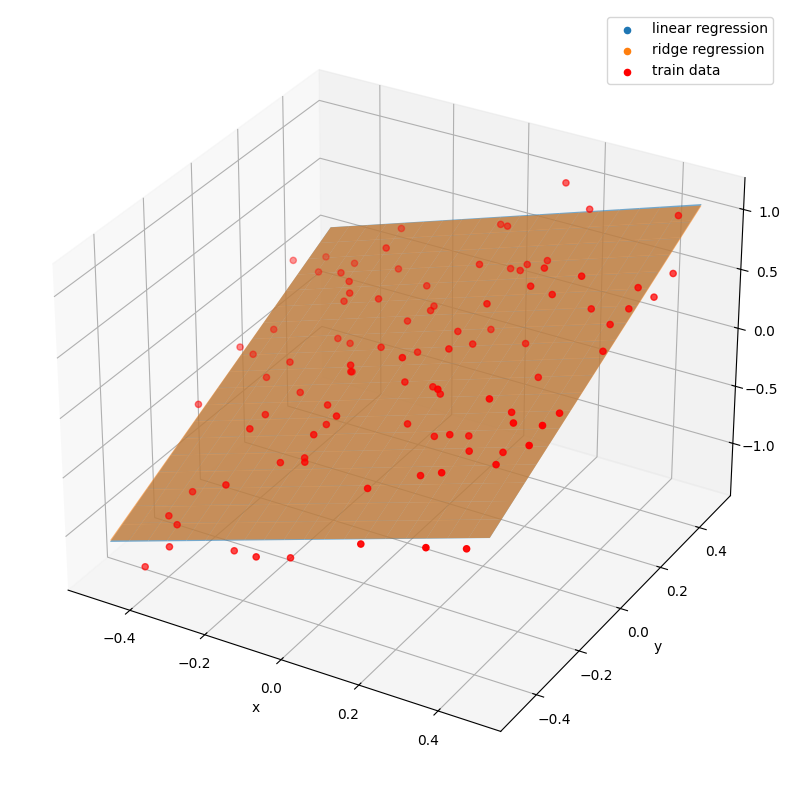

In [11]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection="3d")
x_axis = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 20)
y_axis = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 20)
x_axis, y_axis = np.meshgrid(x_axis, y_axis)
z_axis_1 = theta_linear_regression[0] * x_axis + theta_linear_regression[1] * y_axis
z_axis_2 = theta_ridge_regression[0] * x_axis + theta_ridge_regression[1] * y_axis
# alpha means the transparency of image
ax.plot_surface(x_axis, y_axis, z_axis_1, alpha = 0.6)
ax.plot_surface(x_axis, y_axis, z_axis_2, alpha = 0.6)
# how the first two legend corrspond to its surface correctly?
fake_sct_1 = ax.scatter([], [], [], label="linear regression")
fake_sct_2 = ax.scatter([], [], [], label="ridge regression")
sct = ax.scatter(X[:, 0], X[:, 1], y, label="train data", color='red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

## V. Locally Weighted Linear Regression

Sometimes, the samples we encountered may not be linearly distributed. We can fit a higher order model like quadratic model, but it is hard to predetermine the feature we extract from the data, which may cause underfitting or overfitting. Therefore, locally weighted linear regression, a non-parametric model, can be used to fit the samples. The parameter $\omega$ depends on the particular point x at which we are trying to evaluate.

+ Fit $\theta$ to minimize 
$
\sum _{\boldsymbol i}\omega^{(i)}(\boldsymbol y^{(i)}-\boldsymbol{\theta^{(i)}} \boldsymbol x^{(i)} )^{2},
$
+ output $\theta^T x$

The $\omega^{(i)}$ is the non-negetive valued weightes. Obvously, higher $\omega^{(i)}$ will attach greater importance to its corresponding error $(\boldsymbol y^{(i)}-\boldsymbol{\theta^{(i)}} \boldsymbol x^{(i)} )^{2}$, while ignoring those terms with lower $\omega^{(i)}$.

Usually we choose to compute the $\omega^{(i)}$ as, 

$$
\omega^{(i)} = exp\Big( -\frac{(x^{(i)} − x)^2}{2\tau^2}\Big)
$$

 Moreover, if $|x^{(i)} − x|$ is small, then $\omega^{(i)}$ is close to 1; and if $|x^{(i)} − x|$ is large, then $\omega^{(i)}$ is small.
 
 The $\tau$, the bandwidth parameter, controls how quick a training example $x^{(i)}$ deviates from the query point x.



### Synthsize the dataset

We need to generate a dataset with non-linearity. Here we can use $\sin$ function.

In [14]:
num_features_2 = 1
num_samples_2 = 300

def generate_data2(num_samples, num_features,  function):
    # range of x
    X = np.linspace(-6, 6, 300).reshape(-1, 1)
    # X@y is equivalent to np.matmul(X, y)
    y = function(X)
    return X, y

def mysin(X):
    return np.sin(X).reshape(num_samples_2,)

X_2, y_2 = generate_data2(num_samples_2, num_features_2, mysin)

Text(0.5, 1.0, 'samples frpm sin(x)')

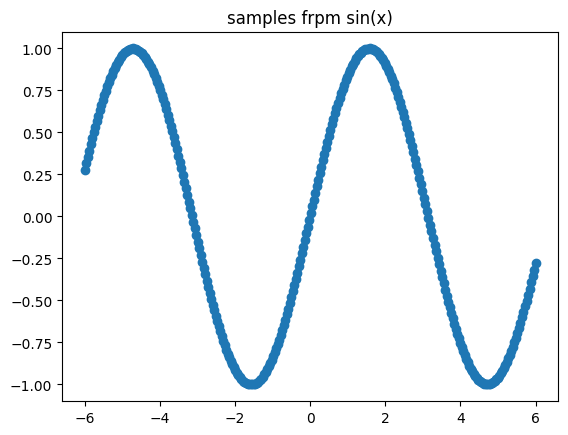

In [15]:
plt.scatter(X_2, y_2)
plt.title('samples frpm sin(x)')

At the above code, we have generated 100 samples from $\sin$ function. In the following step, we need to fit an linear regression model by using locally weighted linear regression method.

#### Q3: Please implement locally weighted linear regression to fit a model which best describes the distribution of samples we generated previously. Please try different hyper-parameter bandwidth $\tau$ to make your model performs better.

Epoch 0/500: theta = [-6.14203157e-13 -8.35102688e-02]
Epoch 100/500: theta = [-6.14203157e-13 -8.35102688e-02]
Epoch 200/500: theta = [-6.14203157e-13 -8.35102688e-02]
Epoch 300/500: theta = [-6.14203157e-13 -8.35102688e-02]
Epoch 400/500: theta = [-6.14203157e-13 -8.35102688e-02]
the MSE Loss of the Locally weighted Linear Regression is [-6.14203157e-13 -8.35102688e-02]
the MSE Loss of the Linear Regression is 0.03814939998213755


Text(0.5, 1.0, 'Fitted curve of the sin(x)')

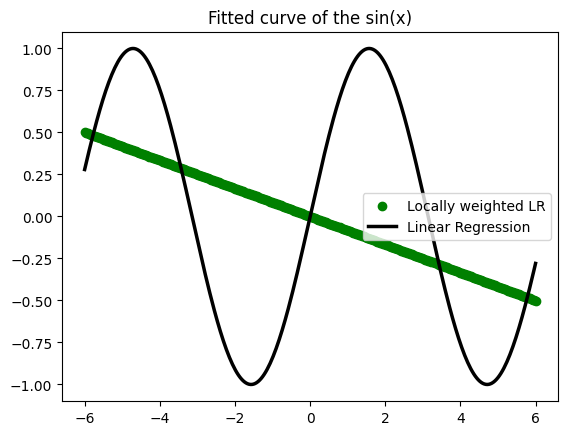

In [19]:
# replace following blanks with your implementation
import numpy as np

# Gaussian kernel function to compute weights
def gaussian_kernel(X, x_query, tau):
    return np.exp(-np.sum((X - x_query) ** 2, axis=1) / (2 * tau ** 2))

# Locally Weighted Linear Regression with Gradient Descent and Regularization
def locally_weighted_Linear_Regression(X, y, max_epoch, alpha, tau, win_len):
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]  # Add bias term to X
    theta = np.zeros(n + 1)  # Initialize theta (with bias)

    for epoch in range(max_epoch):
        for i in range(m):
            x_query = X[i].reshape(1, -1)  # Current query point (single sample)
            
            # Compute weights using the Gaussian kernel
            W = np.diag(gaussian_kernel(X, x_query, tau))
            
            # Regularization term (Ridge regression style)
            L2_reg = alpha * np.eye(n + 1)
            L2_reg[0, 0] = 0  # Do not regularize the bias term
            
            # Compute the weighted X and y
            X_weighted = X_b.T @ W @ X_b
            y_weighted = X_b.T @ W @ y
            
            # Update theta using normal equation with regularization
            theta = np.linalg.inv(X_weighted + L2_reg) @ y_weighted
            
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{max_epoch}: theta = {theta}")
    
    return theta


MSE_error_LWLR = locally_weighted_Linear_Regression(X_2, y_2, 500, 0.0001, 500, 6)
print('the MSE Loss of the Locally weighted Linear Regression is {}'.format(MSE_error_LWLR))

# compute the MESerror of the basic linear model using Normal euqation
theta_LR = linear_regression(X_2, y_2)
y_pred_LR = X_2 @ theta_LR
MSE_error_LR = np.linalg.norm(y_pred_LR - y_2)/num_samples_2
print('the MSE Loss of the Linear Regression is {}'.format(MSE_error_LR))
plt.scatter(X_2, y_pred_LR, color='g')
plt.plot(X_2, y_2, color='black', linewidth=2.5)
plt.legend(['Locally weighted LR', 'Linear Regression', 'graoundtruth'])
plt.title('Fitted curve of the sin(x)')

### Analytic Question

#### Q4: Please plot your result and discuss the effect of $\tau$

**Your answer:** *Write your answer here.*  

1. the $\tau$ controls the rate of decay of the weights, which determines the effect of the distance between the sample point and the query point on the weights.
2. the $\tau$ controls the localization of the model, with smaller t making only nearby sample points queried and larger t making a larger range of samples considered